In [1]:
import os
from pyspark.sql import SparkSession

# start spark master program on this machine and register worker nodes
os.system('start-spark-slurm.sh&') # use & to put it into background

# get ip address of this machine
ip = os.popen('hostname -i').read().strip('\n')
spark = SparkSession.builder \
    .master('spark://' + ip + ':7077') \
    .appName('review') \
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')

Spark Session web UI: http://10.50.222.45:4040


In [2]:
from operator import add
from scipy.sparse import coo_matrix
import json
import string
import numpy as np


with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
    vocab = json.load(f)
    p = len(vocab.keys())
    
def parse_review(x):
    words = set(x.encode('utf-8').lower().translate(string.maketrans("",""), string.punctuation).split())
    ind = [vocab[el] for el in words if el in vocab]
    return coo_matrix((np.ones(len(ind)), (np.zeros(len(ind)), ind)), shape=(1, p)) if len(ind) > 0 else None
    
def parse_rating(x):
    return np.array([x['appearance'], x['aroma'], x['palate'], x['style'], x['taste'], 1.])

[train, val, test] = df.rdd.repartition(28 * 6 * 2).map(
    lambda x: ( 
        float(x['overall'] >= 14), 
        parse_review(x['review'])
    )
).filter(lambda x: x[1] is not None).randomSplit([0.7, 0.15, 0.15])

train.cache()
val.cache()
test.cache()

PythonRDD[14] at RDD at PythonRDD.scala:48

## Logistic Regression using Spark

In [3]:
import time
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint


data = train.map(lambda x: LabeledPoint(x[0], x[1].T))
val_data = val.map(lambda x: LabeledPoint(x[0], x[1].T))

start = time.time()
model = LogisticRegressionWithLBFGS.train(data)
labelsAndPreds = data.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(data.count())
val_labelsAndPreds = val_data.map(lambda p: (p.label, model.predict(p.features)))
valErr = val_labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(val_data.count())
print trainErr, valErr


print time.time() - start

0.199775238464 0.211657482669
354.162693024


## Logistic Regression using SGD and Adam

In [4]:
import time
import scipy.sparse as sp


class Adam():
    
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self._m = 0.
        self._v = 0.
        self._t = 1.

    def update(self, grad):
        self._m += (1. - self.beta1) * (grad      - self._m)
        self._v += (1. - self.beta2) * (grad ** 2 - self._v)
        lr = self.alpha / (1. - self.beta1 ** self._t) / (np.sqrt(self._v) + self.eps)
        self._t += 1
        
        return lr * self._m


class LogisticRegressionSGD():
    
    def __init__(self, spark, tr_data,
                 epoch=1, batch=20,
                 reg=0.,
                 use_adam=False, lr_const=0.1, lr_power=0.5,
                 val_data=None):
        
        self.spark    = spark
        self.tr_data  = tr_data
        self.batch    = batch
        self.epoch    = epoch
        self.reg      = reg
        self.adam     = None if use_adam else Adam()
        self.lr_const = lr_const
        self.lr_power = lr_power
        self.val_data = val_data
        self.beta     = 0
    
    def comp_update(self, grad, t=None):
        if self.adam is not None:
            desc = self.adam.update(grad)
        else:
            lr = self.lr_const / t ** self.lr_power
            desc = grad / np.linalg.norm(grad) * lr
        return desc
        
    def train(self):
    
        def comp_grad(row):
            # y = row[0]
            # x = row[1]
            # r = row[1].dot(beta.value)
            return (1. / (1. + np.exp(-row[1].dot(beta.value))) -  row[0] ) * row[1]

        def comp_nllkh(row):
            # y = row[0]
            # x = row[1]
            r = row[1].dot(beta.value)
            return  np.log(1. + np.exp(r)) -  row[0] * r

        def comp_err(row):
            # y = row[0]
            # x = row[1]
            # r = x.dot(beta.value)
            return float( (row[1].dot(beta.value) >= 0. ) != row[0] )
        
        def comp_stat():
            __tr_nllkh = self.tr_data.map(comp_nllkh).mean() \
                        + self.reg / tr_cnt * np.linalg.norm(beta.value)**2
            __tr_err   = self.tr_data.map(comp_err).mean()
            nllkh.append(__tr_nllkh)
            err.append(__tr_err)
            info = "   === tr nllkh = {} tr err = {}".format(__tr_nllkh, __tr_err)
            
            if self.val_data is not None:
                __val_nllkh = self.val_data.map(comp_nllkh).mean() \
                            + self.reg / val_cnt * np.linalg.norm(beta.value)**2
                __val_err   = self.val_data.map(comp_err).mean()
                val_nllkh.append(__val_nllkh)
                val_err.append(__val_err)
                info += " val nllkh = {} val err = {}".format(__val_nllkh, __val_err)
                
            print info
        
        # initialization
        if self.adam is not None:
            self.adam = Adam()
       
        # training loop
        p = self.tr_data.take(1)[0][1].shape[1]
        beta = self.spark.sparkContext.broadcast(np.zeros(p))
        
        nllkh = []
        err = []
        tr_cnt = self.tr_data.count()
        if self.val_data is not None:
            val_nllkh = [] 
            val_err   = []
            val_cnt   = self.val_data.count() 
        comp_stat()
        
        cnt = 0
        for kk in xrange(self.epoch):
            print " * Epoch %d" % kk
            batches = self.tr_data.randomSplit(np.ones(self.batch))
            for tt in xrange(self.batch):
                cnt += 1
                grad = batches[tt].map(comp_grad).reduce(np.add) + self.reg * beta.value
                update = 10. * self.comp_update(grad, cnt)
                beta = spark.sparkContext.broadcast(beta.value - update)
                print "    - iter %d grad norm = %f update norm = %f beta norm = %f" % (
                    tt,
                    np.linalg.norm(grad),
                    np.linalg.norm(update),
                    np.linalg.norm(beta.value)
                )
                if cnt % 10 == 0 or cnt == self.epoch * self.batch:
                    stat = comp_stat()
                    
        self.beta = beta.value
            
        return (nllkh, err, beta.value) if self.val_data is None else (nllkh, err, val_nllkh, val_err, beta.value)


In [5]:
import time
start   = time.time() 

reg_params = [0.1, 1, 5, 10, 100]
tr_nllkh   = [0] * len(reg_params)
tr_err     = [0] * len(reg_params)
val_nllkh  = [0] * len(reg_params) 
val_er     = [0] * len(reg_params)
beta       = [0] * len(reg_params)

for ii in xrange(len(reg_params)):
    print "training with lambda = %f" % reg_params[ii] 
    model = LogisticRegressionSGD(spark, train, reg=reg_params[ii], epoch=3, batch=30, use_adam=True, val_data=val)
    tr_nllkh[ii], tr_err[ii], val_nllkh[ii], val_err[ii], beta[ii] = model.train()
print time.time() - start   

training with lambda = 0.100000
   === tr nllkh = [ 0.69314718] tr err = 0.462595972715 val nllkh = [ 0.69314718] val err = 0.4622028667
 * Epoch 0
    - iter 0 grad norm = 7343.258456 update norm = 1.000000 beta norm = 1.000000
    - iter 1 grad norm = 7505.109709 update norm = 0.707107 beta norm = 1.114183
    - iter 2 grad norm = 4465.246464 update norm = 0.577350 beta norm = 1.586349
    - iter 3 grad norm = 4220.279644 update norm = 0.500000 beta norm = 1.821302
    - iter 4 grad norm = 3694.518018 update norm = 0.447214 beta norm = 2.118518
    - iter 5 grad norm = 3228.469170 update norm = 0.408248 beta norm = 2.325969
    - iter 6 grad norm = 2806.241998 update norm = 0.377964 beta norm = 2.569595
    - iter 7 grad norm = 2595.406532 update norm = 0.353553 beta norm = 2.746361
    - iter 8 grad norm = 2313.947986 update norm = 0.333333 beta norm = 2.952734
    - iter 9 grad norm = 2131.375576 update norm = 0.316228 beta norm = 3.110567
   === tr nllkh = [ 0.53232723] tr err = 0

NameError: name 'val_err' is not defined

In [7]:
train_val = train.union(val)
model = LogisticRegressionSGD(spark, train_val, reg=5, epoch=3, batch=30, use_adam=True, val_data=test)
rst = model.train()

   === tr nllkh = [ 0.69314718] tr err = 0.462526740187 val nllkh = [ 0.69314718] val err = 0.464175447522
 * Epoch 0
    - iter 0 grad norm = 8920.844789 update norm = 1.000000 beta norm = 1.000000
    - iter 1 grad norm = 9003.276299 update norm = 0.707107 beta norm = 1.107918
    - iter 2 grad norm = 5394.530666 update norm = 0.577350 beta norm = 1.584400
    - iter 3 grad norm = 5216.001172 update norm = 0.500000 beta norm = 1.816539
    - iter 4 grad norm = 4431.682338 update norm = 0.447214 beta norm = 2.117851
    - iter 5 grad norm = 3819.470080 update norm = 0.408248 beta norm = 2.326358
    - iter 6 grad norm = 3589.334633 update norm = 0.377964 beta norm = 2.561367
    - iter 7 grad norm = 3193.378654 update norm = 0.353553 beta norm = 2.723055
    - iter 8 grad norm = 2882.544650 update norm = 0.333333 beta norm = 2.926470
    - iter 9 grad norm = 2699.598795 update norm = 0.316228 beta norm = 3.076942
   === tr nllkh = [ 0.53351864] tr err = 0.257202893395 val nllkh = [ 0.

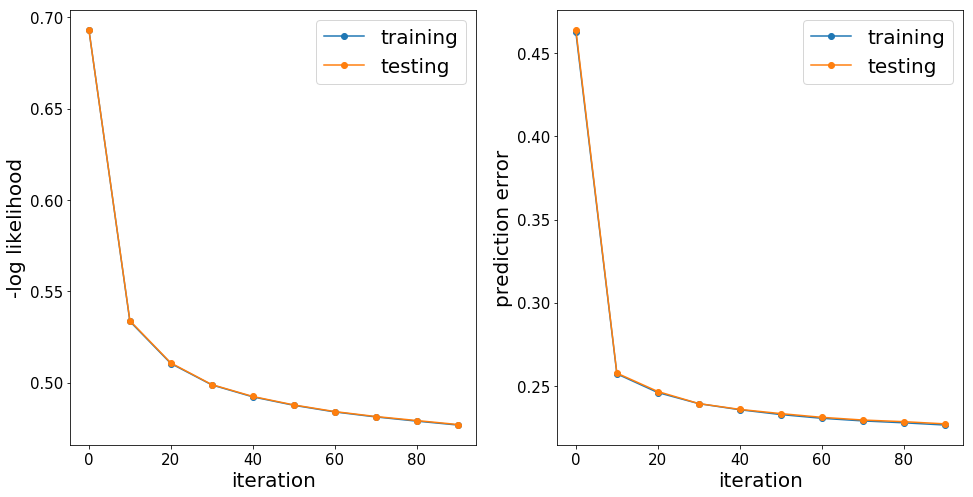

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

def plot_rst(tr_nllkh, tr_err, val_nllkh, val_err):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121)
    ax.plot(xrange(0, len(tr_nllkh) * 10, 10), tr_nllkh, 'o-')
    ax.plot(xrange(0, len(tr_nllkh) * 10, 10), val_nllkh, 'o-')
    ax.set_ylabel('-log likelihood', fontsize=20)
    ax.set_xlabel('iteration', fontsize=20)
    ax.legend( ['training', 'testing'], fontsize=20)

    ax = fig.add_subplot(122)
    ax.plot(xrange(0, len(tr_nllkh) * 10, 10), tr_err, 'o-')
    ax.plot(xrange(0, len(tr_nllkh) * 10, 10), val_err, 'o-')
    ax.set_ylabel('prediction error', fontsize=20)
    ax.set_xlabel('iteration', fontsize=20)
    ax.legend( ['training', 'testing'], fontsize=20)

plot_rst(rst[0], rst[1], rst[2], rst[3])